## 1a. Digital Elevation Model preparation
This notebook goes through the steps to prepare the PGC, AeroDEM, and GrIMP DEM for analysis and how to extract the Height above bouyancy values.

At this time, the notebook requires you to have QGIS to for some of the steps.

This notebook is primarily for preping the data. You do not need to run this notebook to recreate the figures. All sampled data is already avaible to be used.

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import shutil
from datetime import datetime
import pandas as pd
from shapely.affinity import translate
import rasterio
import sys

from terminus import termpicks_trace, termpicks_centerline, termpicks_interpolation
from dem_funcs import reproj_match,near

In [ ]:
#uploads the king data thickness summary that is used for calculating the stress coupling distance for the glacier of intrest
kingdata = pd.read_csv('King_data_summary.csv')

Input the glacier ID for the glacier of intrest and calculate the stress coupling distance estimate from Enderlin et al. 2013

In [ ]:
glacierid = '3'
thickness = kingdata[kingdata['GlacierID']==int(glacierid)]['thick_mean'].values[0]
stresscoup_dist = int((thickness*4)/30)

Load a dataset for terminus traces (this is only used to crop if the traces match the date of the DEM) and PGC DEMS obtained from PCG site

In [ ]:
termpicks = gpd.read_file('Terminus/TermPicks+Calfin_v2/TermPicks_Zhang_KAS_ls_edtied_v3.shp')
termpicks = termpicks[termpicks['GlacierID']==int(glacierid)]

In [13]:
dems = os.listdir('PGC_DEMS/' + glacierid)
masked = []
for file in dems:
    if file.endswith("dem_masked.tif"):
        masked.append(file)

Manually approve DEMs for completeness. Images of the DEM will appear and indicate 'y' for good, 'n' for bad. 

In [ ]:

approve = []
for file in masked:
    lidar_chm_im = rxr.open_rasterio("PGC_DEMS/"+glacierid+"/" + file,
                                 masked=True).squeeze()

    f, ax = plt.subplots(figsize=(10, 5))
    lidar_chm_im.plot.imshow()
    ax.set_axis_off()
    plt.show()
    
    approve.append(input())

final = []
for file, app in zip(masked,approve):
    if app == 'y':
        final.append(file)
        scr = 'PGC_DEMS/' + glacierid+'/'+file
        dst = "Approved_DEMS/"+glacierid+"/" + file
        shutil.copyfile(scr, dst)
        
df = pd.DataFrame(final,columns=['approved']) 
# saving the dataframe 
df.to_csv("DEM_approve/"+glacierid+".csv")

In [13]:
#if already approved
df = pd.read_csv("DEM_approve/"+glacierid+".csv")
final = df['approved'].to_list()

Once approved, match terminus trace dates to DEM dates.

In [14]:
#Get the DEM dates list
dem_dates = []
for dem in final:
    f_date = dem[18:26]
    y = f_date[0:4]
    m= f_date[4:6]
    d = f_date[6:8]
    date = y + '-' + m + '-' + d
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    dem_dates.append(datetime_object)

#Get the Zhang dates list
z_term_direct= os.listdir('Terminus/Zhang/Shapefiles')
z_terminus_traces =[item for item in z_term_direct if item.endswith('.shp')]
zhang_dates = []
for trace in z_terminus_traces:
    z_date = trace[4:12]
    y = z_date[0:4]
    m= z_date[4:6]
    d = z_date[6:8]
    date = y + '-' + m + '-' + d
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    zhang_dates.append(datetime_object)
    
#Get the TermPicks date list
tp_datestr = termpicks['Date'].to_list()
tp_dates = []
for date in tp_datestr:
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    tp_dates.append(datetime_object)



In [15]:
#get the terminus trace that corresponds to the glacier dem date
indexs = []
for date,file in zip(dem_dates,final):
    if date in zhang_dates:
        indexs.append((file,date,'zhang',zhang_dates.index(date)))
    elif date in tp_dates:
        indexs.append((file,date,'tp',tp_dates.index(date)))
    #elif date in n_dates:
        #indexs.append((file,date,'new',n_dates.index(date)))
    else:
        indexs.append((file,date,'none',1))
dem_df = pd.DataFrame(indexs, columns =['DEM','Date','Terminus','Index']) 
need_picks = dem_df[dem_df['Terminus'] == 'none']['DEM'].to_list()

##Copies the DEMs that needed terminus traces to the approved location
for file in need_picks:
    scr = 'Approved_DEMS/'+glacierid+ '/' + file
    dst = 'Approved_DEMS/Need_picks/'+glacierid +'/' +  file
    shutil.copyfile(scr, dst)

If any are missing, users will need to use the folder "Approved DEMs/Need_picks" to manually trace dates where there was no terminus trace that overlapped.

In [16]:
#Get the DEM dates list
dem_dates = []
for dem in final:
    f_date = dem[18:26]
    y = f_date[0:4]
    m= f_date[4:6]
    d = f_date[6:8]
    date = y + '-' + m + '-' + d
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    dem_dates.append(datetime_object)

#Get the Zhang dates list
z_term_direct= os.listdir('Terminus/Zhang/Shapefiles')
z_terminus_traces =[item for item in z_term_direct if item.endswith('.shp')]
zhang_dates = []
for trace in z_terminus_traces:
    z_date = trace[4:12]
    y = z_date[0:4]
    m= z_date[4:6]
    d = z_date[6:8]
    date = y + '-' + m + '-' + d
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    zhang_dates.append(datetime_object)
    
#Get the TermPicks date list
tp_datestr = termpicks['Date'].to_list()
tp_dates = []
for date in tp_datestr:
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    tp_dates.append(datetime_object)

#Get new picks dates to list

n_picks = gpd.read_file('Terminus/New_traces/DEM_Traces_by_id/DEM_Traces_polar_'+glacierid+'.shp')
n_picks = n_picks.to_crs("EPSG:3413")
n_datestr = n_picks['Date'].to_list()
n_dates = []
for date in n_datestr:
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    n_dates.append(datetime_object)
    
#get the terminus trace that corresponds to the glacier dem date
indexs = []
for date,file in zip(dem_dates,final):
    if date in zhang_dates:
        indexs.append((file,date,'zhang',zhang_dates.index(date)))
    elif date in tp_dates:
        indexs.append((file,date,'tp',tp_dates.index(date)))
    elif date in n_dates:
        indexs.append((file,date,'new',n_dates.index(date)))
    else:
        indexs.append((file,date,'none',1))
dem_df = pd.DataFrame(indexs, columns =['DEM','Date','Terminus','Index']) 
need_picks = dem_df[dem_df['Terminus'] == 'none']['DEM'].to_list()

##Copies the DEMs that needed terminus traces to the approved location
for file in need_picks:
    scr = 'Approved_DEMS/'+glacierid+ '/' + file
    dst = 'Approved_DEMS/Need_picks/'+glacierid +'/' +  file
    shutil.copyfile(scr, dst)

In [17]:
#After tracing the new termini in QGIS
source = dem_df['Terminus'].to_list()
index = dem_df['Index'].to_list()

termini = []
for name,i in zip(source,index):
    if name == 'zhang':
        term = gpd.read_file('Terminus/Shapefiles/'+z_terminus_traces[i])
        geom = term['geometry'][0]
        termini.append(geom)
    elif name == 'tp':
        geom = termpicks.iloc[i]['geometry']
        termini.append(geom)
    elif name == 'new':
        geom = n_picks.iloc[i]['geometry']
        termini.append(geom)
        
dem_df['geometry'] = termini   
termini_gdf = gpd.GeoDataFrame(dem_df, crs="EPSG:3413", geometry=dem_df['geometry'])
termini_gdf['Date'] = termini_gdf['Date'].dt.strftime('%Y-%m-%d').to_list()
termini_gdf.to_file('Terminus/New_traces/DEM_Traces_by_id/DEM_Traces_polar_'+glacierid+'.shp')

In [18]:
source = dem_df['Terminus'].to_list()
index = dem_df['Index'].to_list()


After DEMs are identified, upload the DEM polygons. These are used to subset the DEMs by the stress coupling distance.

In [ ]:
#OPEN DEM POLYGONS
polygons = gpd.read_file('DEM_sample_polygons/DEM_polygons.shp')
polygon = polygons[polygons['GlacierID']==int(glacierid)]

#OPEN CENTERLINES AND GET POINTS
centerlines_df = gpd.read_file('Centerlines/termpicks_centerlines/termpicks_centerlines.shp')
centerline_points = termpicks_centerline(centerlines_df,int(glacierid)).line2points(n_vert = 30)
centerline_points.plot(column = 'cumsum', legend=True)

#get cetroids of the termini
centroids = termini_gdf.centroid.to_list()

Then, project the terminus that cooresponds to the front of the glacier in the DEM to the lenghth of the stress coulpling distance up the glacier. 

In [20]:
#FINDING NEW LOCATION OF TERMINI BASED ON STRESS COUPLING DISTANCE
indexs_closest = []
for i in centroids:
    closest = near(i,centerline_points)
    indexs_closest.append( closest)
new_spot_index = [i-stresscoup_dist for i in indexs_closest]

x=[]
y=[]
for new,old in zip(new_spot_index,indexs_closest):
    
    new_y = centerline_points.iloc[new]['geometry'].y
    new_x = centerline_points.iloc[new]['geometry'].x
    
    old_y = centerline_points.iloc[old]['geometry'].y
    old_x = centerline_points.iloc[old]['geometry'].x
    
    trans_y = new_y-old_y
    trans_x = new_x-old_x
    
    x.append(trans_x)
    y.append(trans_y)
    
tmp = []
for index, poi in termini_gdf.iterrows():
    new_point = translate(termini_gdf.loc[index, 'geometry'], xoff=x[index], yoff=y[index])
    tmp.append({'geometry':new_point})

scd = gpd.GeoDataFrame(tmp,crs="EPSG:3413")
scd['Date'] = termini_gdf['Date']


scd.to_file('Terminus/New_traces/SCD_Termini/scd_termini_by_id/scd_termini_'+glacierid+'.shp')

Currently, you need to go into QGIS to extend the shapefiles "pickscd_e" to make sure that they intersect the DEM_polygons. Once that is complete, create a polygons that will be used to crop the DEMs by the stress coupling distance.


In [21]:
scd_e = gpd.read_file('Terminus/New_traces/SCD_Termini/scd_termini_by_id/scd_termini_'+glacierid+'_extended.shp')
scd_e = scd_e.sort_values(by=['Date'],ignore_index=True)

termini_gdf = gpd.read_file('Terminus/New_traces/DEM_Traces_by_id/DEM_Traces_polar_'+glacierid+'_extended.shp')
termini_gdf = termini_gdf.sort_values(by=['Date'],ignore_index=True)

loop = termini_gdf.index.to_list()
new_polygons = []
for i in loop:

    line1 = termini_gdf.iloc[i]['geometry']
    line2 = scd_e.iloc[i]['geometry']

    line1_pol = line1.buffer(1e-3)
    line2_pol = line2.buffer(1e-3)

    new_polygon = polygon.difference(line1_pol).difference(line2_pol)

    new_polygon = gpd.GeoDataFrame(new_polygon, crs="EPSG:3413", geometry = 0)
    exploded = new_polygon.explode(index_parts=True)
    if len(exploded) == 3:
        exploded['area'] = exploded.area
        exploded = exploded.loc[exploded['area']!=exploded['area'].max()]
        exploded = exploded.loc[exploded['area']!=exploded['area'].max()]
        new_polygons.append(exploded.iloc[0][0])
    else:
        exploded.plot()
        print(i)
termini_gdf['geometry'] = new_polygons

termini_gdf.to_file('DEM_sample_polygons/SC_crop/'+glacierid+'.shp')

Crop the DEMs by the new polygons.

In [22]:
dems = termini_gdf['DEM'].to_list()
indx = termini_gdf.index.to_list()
for dem, i in zip(dems,indx):

    dem_path = os.path.join('Approved_DEMS/'+glacierid+'/', dem)

    dem_im = rxr.open_rasterio(dem_path,
                                     masked=True).squeeze()
    crop_extent = termini_gdf[termini_gdf.index == i]
    clipped = dem_im.rio.clip(crop_extent.geometry.apply(mapping))
    path_to_tif_file = os.path.join("clipped_DEMS/",glacierid, crop_extent['DEM'].to_list()[0])

    # Write the data to a new geotiff file
    clipped.rio.to_raster(path_to_tif_file)




Open the appropriate bed data and crop the bed to the same polygon used to crop the DEMs.

In [23]:
bed = rxr.open_rasterio('BedMachine/bed+geoid.tif', masked=True).squeeze()

indx = termini_gdf.index.to_list()
for i in indx:
    crop_extent = termini_gdf[termini_gdf.index == i]
    clipped = bed.rio.clip(crop_extent.geometry.apply(mapping))
    path_to_tif_file = os.path.join("BedMachine\\Clipped_bed",glacierid,
                                    'bed_'+crop_extent['DEM'].to_list()[0])

    # Write the data to a new geotiff file
    clipped.rio.to_raster(path_to_tif_file)


Calcualte the Height above bouyancy for each DEM and save it to a .tif

In [ ]:
file_loop = termini_gdf['DEM'].to_list()
means=[]
medians=[]
counts=[]
stds=[]
for file in file_loop:
    bed_path = 'BedMachine/Clipped_bed/'+glacierid+'/bed_'+file
    dem_path = 'Clipped_DEMs/'+glacierid+'/'+file
    
    #make sure the DEM and bed are co-registered 
    reproj_match(dem_path,bed_path,'Clipped_DEMs/150m/'+glacierid+'/150_'+file)


    b = rxr.open_rasterio('BedMachine/Clipped_bed/'+glacierid+'/bed_'+file, masked=True).squeeze()
    d =  rxr.open_rasterio('Clipped_DEMs/150m/'+glacierid+'/150_'+file, masked=True).squeeze()


    ice_den = (b * 1.14)
    thickness = d - b
    hab = thickness+ice_den

    means.append(hab.mean().to_numpy().tolist())
    medians.append(hab.median().to_numpy().tolist())
    counts.append(hab.count().to_numpy().tolist())
    stds.append(hab.std().to_numpy().tolist())


    hab.rio.to_raster('HAB/'+glacierid+'/hab_'+file)

Sample the cropped DEMs to get the mean, median, STD, and counts for each DEM.

In [25]:
termini_gdf['mean'] = means
termini_gdf['median'] = medians
termini_gdf['std'] = stds
termini_gdf['counts'] = counts

termini_gdf.to_file('HAB_Sampled/'+glacierid+'.shp')

## AeroDEM Steps

The following processing steps are for the AeroDEM. They are currently seperate, but future versions will include a more streamlined notebook for calculating all DEMs regardless of source.

In [6]:
glacierid = '3'

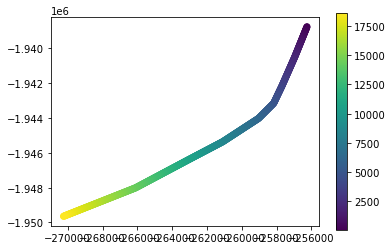

In [46]:
#OPEN DEM POLYGONS
polygons = gpd.read_file('DEM_sample_polygons/DEM_polygons.shp')
polygon = polygons[polygons['GlacierID']==int(glacierid)]

#OPEN CENTERLINES AND GET POINTS
centerlines_df = gpd.read_file('Centerlines/termpicks_centerlines/termpicks_centerlines.shp')
centerline_points = termpicks_centerline(centerlines_df,int(glacierid)).line2points(n_vert = 30)
centerline_points.plot(column = 'cumsum', legend=True)

termini_gdf = gpd.read_file('AeroDEM/aerodem_crops/aerodem_termini_polar.shp')
termini_gdf = termini_gdf[termini_gdf['id']== int(glacierid)]
termini_gdf=termini_gdf.to_crs(3413)
#get cetroids of the termini
centroids = termini_gdf.centroid.to_list()

In [31]:
#FINDING NEW LOCATION OF TERMINI BASED ON STRESS COUPLING DISTANCE
indexs_closest = []
for i in centroids:
    closest = near(i,centerline_points)
    indexs_closest.append( closest)
new_spot_index = [i-stresscoup_dist for i in indexs_closest]

x=[]
y=[]
for new,old in zip(new_spot_index,indexs_closest):
    
    new_y = centerline_points.iloc[new]['geometry'].y
    new_x = centerline_points.iloc[new]['geometry'].x
    
    old_y = centerline_points.iloc[old]['geometry'].y
    old_x = centerline_points.iloc[old]['geometry'].x
    
    trans_y = new_y-old_y
    trans_x = new_x-old_x
    
    x.append(trans_x)
    y.append(trans_y)
    
tmp = []
for index, poi in termini_gdf.iterrows():
    new_point = translate(termini_gdf.loc[index, 'geometry'], xoff=x[0], yoff=y[0])
    tmp.append({'geometry':new_point})

scd = gpd.GeoDataFrame(tmp,crs="EPSG:3413")


scd.to_file('AeroDEM/aerodem_crops/scd_termini_'+glacierid+'.shp')

In [47]:
scd_e = gpd.read_file('AeroDEM/aerodem_crops/scd_termini_'+glacierid+'_extended.shp')

line1 = termini_gdf['geometry'].values[0]
line2 = scd_e['geometry'].values[0]

line1_pol = line1.buffer(1e-3)
line2_pol = line2.buffer(1e-3)

new_polygon = polygon.difference(line1_pol).difference(line2_pol)

new_polygon = gpd.GeoDataFrame(new_polygon, crs="EPSG:3413", geometry = 0)
exploded = new_polygon.explode(index_parts=True)
    
exploded['area'] = exploded.area
exploded = exploded.loc[exploded['area']!=exploded['area'].max()]
exploded = exploded.loc[exploded['area']!=exploded['area'].max()]
termini_gdf['geometry'] = exploded.iloc[0][0]

termini_gdf.to_file('AeroDEM/SC_crop/'+glacierid+'.shp')

In [50]:
dem_path = os.path.join('AeroDEM/by_glacier/aero_'+glacierid+'.tif')

dem_im = rxr.open_rasterio(dem_path,
                                 masked=True).squeeze()
crop_extent = termini_gdf
clipped = dem_im.rio.clip(crop_extent.geometry.apply(mapping))
path_to_tif_file = os.path.join("AeroDEM\\by_glacier\\clipped_DEMS\\",glacierid +'.tif')
# Write the data to a new geotiff file
clipped.rio.to_raster(path_to_tif_file)

In [51]:
hab =  rxr.open_rasterio('AeroDEM/by_glacier/clipped_DEMS/'+glacierid+'.tif', masked=True).squeeze()

mean = hab.mean().to_numpy().tolist()
median = hab.median().to_numpy().tolist()
counts = hab.count().to_numpy().tolist()
stds= hab.std().to_numpy().tolist()


hab.rio.to_raster('AeroDEM/HAB/'+glacierid+'_hab.tif')

hab_sample = gpd.read_file('HAB_Sampled/'+glacierid+'.shp')
aero_df = {'DEM': 'AeroDEM', 'Date':'1985-07-02', 'mean': mean, 'median': median, 'std': stds, 'counts': counts, 'geometry': termini_gdf['geometry'].values[0]}
df = hab_sample.append(aero_df, ignore_index = True)
df.to_file('HAB_Sampled/'+glacierid+'.shp')

In [53]:
df.to_file('HAB_Sampled/'+glacierid+'.shp')

## GrIMP DEM Steps

The following processing steps are for the GrIMP DEM. They are currently seperate, but future versions will include a more streamlined notebook for calculating all DEMs regardless of source.

In [54]:
glacierid = '3'
kingdata = pd.read_csv('King_data_summary.csv')
thickness = kingdata[kingdata['GlacierID']==int(glacierid)]['thick_mean'].values[0]
stresscoup_dist = int((thickness*4)/30)

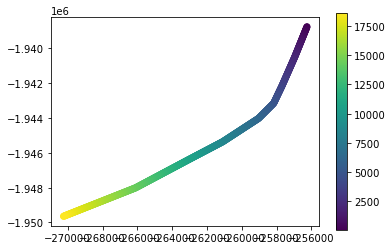

In [55]:
#OPEN DEM POLYGONS
polygons = gpd.read_file('DEM_sample_polygons/DEM_polygons.shp')
polygon = polygons[polygons['GlacierID']==int(glacierid)]

#OPEN CENTERLINES AND GET POINTS
centerlines_df = gpd.read_file('Centerlines/termpicks_centerlines/termpicks_centerlines.shp')
centerline_points = termpicks_centerline(centerlines_df,int(glacierid)).line2points(n_vert = 30)
centerline_points.plot(column = 'cumsum', legend=True)


#termini_gdf = gpd.read_file('GIMP/gimp_crops/1_2.shp')
termini_gdf = gpd.read_file('GIMP/gimp_crops/1_3.shp')
termini_gdf = termini_gdf[termini_gdf['id']== int(glacierid)]
termini_gdf=termini_gdf.to_crs(3413)
#get cetroids of the termini
centroids = termini_gdf.centroid.to_list()

#FINDING NEW LOCATION OF TERMINI BASED ON STRESS COUPLING DISTANCE
indexs_closest = []
for i in centroids:
    closest = near(i,centerline_points)
    indexs_closest.append( closest)
new_spot_index = [i-stresscoup_dist for i in indexs_closest]

x=[]
y=[]
for new,old in zip(new_spot_index,indexs_closest):
    
    new_y = centerline_points.iloc[new]['geometry'].y
    new_x = centerline_points.iloc[new]['geometry'].x
    
    old_y = centerline_points.iloc[old]['geometry'].y
    old_x = centerline_points.iloc[old]['geometry'].x
    
    trans_y = new_y-old_y
    trans_x = new_x-old_x
    
    x.append(trans_x)
    y.append(trans_y)
    
tmp = []
for index, poi in termini_gdf.iterrows():
    new_point = translate(termini_gdf.loc[index, 'geometry'], xoff=x[0], yoff=y[0])
    tmp.append({'geometry':new_point})

scd = gpd.GeoDataFrame(tmp,crs="EPSG:3413")


scd.to_file('GIMP/gimp_crops/scd_termini_'+glacierid+'.shp')

In [56]:
scd_e = gpd.read_file('GIMP/gimp_crops/scd_termini_'+glacierid+'.shp')

line1 = termini_gdf['geometry'].values[0]
line2 = scd_e['geometry'].values[0]

line1_pol = line1.buffer(1e-3)
line2_pol = line2.buffer(1e-3)

new_polygon = polygon.difference(line1_pol).difference(line2_pol)

new_polygon = gpd.GeoDataFrame(new_polygon, crs="EPSG:3413", geometry = 0)
exploded = new_polygon.explode(index_parts=True)
    
exploded['area'] = exploded.area
exploded = exploded.loc[exploded['area']!=exploded['area'].max()]
exploded = exploded.loc[exploded['area']!=exploded['area'].max()]
termini_gdf['geometry'] = exploded.iloc[0][0]

termini_gdf.to_file('GIMP/SC_crop/'+glacierid+'.shp')

dem_path = os.path.join('GIMP/gimpdem1_3_v01.1.tif')
#dem_path = os.path.join('GIMP/gimpdem1_2_v01.1.tif')

dem_im = rxr.open_rasterio(dem_path,
                                 masked=True).squeeze()
crop_extent = termini_gdf
clipped = dem_im.rio.clip(crop_extent.geometry.apply(mapping))
path_to_tif_file = os.path.join("GIMP/by_glacier",glacierid +'.tif')
# Write the data to a new geotiff file
clipped.rio.to_raster(path_to_tif_file)

bed = rxr.open_rasterio('BedMachine/bed+geoid.tif', masked=True).squeeze()

indx = termini_gdf.index.to_list()
for i in indx:
    crop_extent = termini_gdf[termini_gdf.index == i]
    clipped = bed.rio.clip(crop_extent.geometry.apply(mapping))
    path_to_tif_file = os.path.join("GIMP/bed/",glacierid +
                                    'bed.tif')

    # Write the data to a new geotiff file
    clipped.rio.to_raster(path_to_tif_file)

bed_path = os.path.join("GIMP/bed/",glacierid +'bed.tif')
dem_path = os.path.join("GIMP/by_glacier",glacierid +'.tif')


reproj_match(dem_path,bed_path,"GIMP/by_glacier/"+glacierid +'_150.tif')


b = rxr.open_rasterio(bed_path, masked=True).squeeze()
d =  rxr.open_rasterio("GIMP/by_glacier/"+glacierid +'_150.tif', masked=True).squeeze()


ice_den = (b * 1.14)
thickness = d - b
hab = thickness+ice_den

hab.rio.to_raster('GIMP/HAB/'+glacierid+'_hab_.tif')

mean = hab.mean().to_numpy().tolist()
median = hab.median().to_numpy().tolist()
counts = hab.count().to_numpy().tolist()
stds= hab.std().to_numpy().tolist()
hab_sample = gpd.read_file('HAB_Sampled/'+glacierid+'.shp')
aero_df = {'DEM': 'GIMP', 'Date':'2007-07-02', 'mean': mean, 'median': median, 'std': stds, 'counts': counts, 'geometry': termini_gdf['geometry'].values[0]}
df = hab_sample.append(aero_df, ignore_index = True)
df.to_file('HAB_Sampled/'+glacierid+'.shp')

C:\Users\sofyg\Anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:2947: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return runner(coro)


Coregistered to shape: 23 15 
 Affine | 150.00, 0.00,-264350.00|
| 0.00,-150.00,-1944950.00|
| 0.00, 0.00, 1.00|
